# Crimes in Boston
(https://www.kaggle.com/AnalyzeBoston/crimes-in-boston)

This project covers data cleaning, feature selection, Exploratory Data Analysis followed by Forecasting Future crimes rates using SARIMAX.

<font size ='4'>**Objective**</font>

In [3]:
from gtts import gTTS
from IPython.display import Audio

* I was able to draw insights & answer the following questions
* **For insights go to the last cell of this notebook**
* Just run the 2 columns below to hear the results drawn from the analysis

In [2]:
tts=gTTS("""
Is Incident Number a unique column?
What types of crimes are most common?
Which District and UCR has highest crime rate?
Where are different types of crimes most likely to occur?
Does the frequency of crimes change over the day? Week? Year?
Analysing the occurance of top 5 crimes based on Weekday!
Forecasting the daily frequency of crimes!
""")

In [4]:
tts.save('objective.wav')
Audio('objective.wav',autoplay=True)

________________________________________________________________________________

Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from warnings import filterwarnings as fw
fw('ignore')

In [2]:
sns.set_style('darkgrid')
sns.set_palette('viridis')


Importing data & dropping latitide and longitude data 

In [3]:
df=pd.read_csv('crime.csv',encoding='Latin-1',parse_dates=['OCCURRED_ON_DATE'],index_col='OCCURRED_ON_DATE').drop(['Lat', 'Long', 'Location' ],axis=1)

In [4]:
df.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET
OCCURRED_ON_DATE,,,,,,,,,,,,,
2018-09-02 13:00:00,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018,9,Sunday,13,Part One,LINCOLN ST
2018-08-21 00:00:00,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018,8,Tuesday,0,Part Two,HECLA ST
2018-09-03 19:27:00,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018,9,Monday,19,Part Three,CAZENOVE ST
2018-09-03 21:16:00,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018,9,Monday,21,Part Three,NEWCOMB ST
2018-09-03 21:05:00,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018,9,Monday,21,Part Three,DELHI ST


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 319073 entries, 2018-09-02 13:00:00 to 2015-06-22 00:12:00
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   INCIDENT_NUMBER      319073 non-null  object
 1   OFFENSE_CODE         319073 non-null  int64 
 2   OFFENSE_CODE_GROUP   319073 non-null  object
 3   OFFENSE_DESCRIPTION  319073 non-null  object
 4   DISTRICT             317308 non-null  object
 5   REPORTING_AREA       319073 non-null  object
 6   SHOOTING             1019 non-null    object
 7   YEAR                 319073 non-null  int64 
 8   MONTH                319073 non-null  int64 
 9   DAY_OF_WEEK          319073 non-null  object
 10  HOUR                 319073 non-null  int64 
 11  UCR_PART             318983 non-null  object
 12  STREET               308202 non-null  object
dtypes: int64(4), object(9)
memory usage: 34.1+ MB


# Dealing with missing data

In [6]:
def missing(data,x=5):
    data_info=pd.DataFrame(index=data.columns)
    data_info['% missing']=[sum(data[i].isnull())/len(data[i])*100 for i in data_info.index]
    data_info['value_count']=[ dict(data[i].value_counts()) for i in data_info.index]
    data_info['data_type']=[data[i].dtypes for i in data_info.index]
    data_info=data_info.sort_values(by='% missing',ascending=False)
    return data_info.head(x)

In [7]:
missin=missing(df,6)
missin

,% missing,value_count,data_type
SHOOTING,99.680637,{'Y': 1019},object
STREET,3.407057,"{'WASHINGTON ST': 14194, 'BLUE HILL AVE': 7794...",object
DISTRICT,0.553165,"{'B2': 49945, 'C11': 42530, 'D4': 41915, 'A1':...",object
UCR_PART,0.028207,"{'Part Three': 158553, 'Part Two': 97569, 'Par...",object
INCIDENT_NUMBER,0.000000,"{'I162030584': 13, 'I152080623': 11, 'I1720131...",object
OFFENSE_CODE,0.000000,"{3006: 18783, 3115: 18754, 3831: 16323, 1402: ...",int64


Imputing Missing values

Though Shooting column is almost empty but for EDA purpose we will use it (Mapping the nan values in shooting column with 0 and Y as 1)

In [8]:
df['SHOOTING']=df['SHOOTING'].map({'Y':1,np.nan:0})

For geographical locations lets start with the least granular geographical feature District

In [9]:
df['DISTRICT'].fillna(df['DISTRICT'].value_counts().index[0],inplace=True) #using mode to fill missing district values

We don't need Street for our EDA so we'll drop that and Impute UCR_PART

In [10]:
df['UCR_PART'].fillna(df['UCR_PART'].value_counts().index[0],inplace=True) #using mode to fill missing district values

In [11]:
df.columns

Index(['INCIDENT_NUMBER', 'OFFENSE_CODE', 'OFFENSE_CODE_GROUP',
       'OFFENSE_DESCRIPTION', 'DISTRICT', 'REPORTING_AREA', 'SHOOTING', 'YEAR',
       'MONTH', 'DAY_OF_WEEK', 'HOUR', 'UCR_PART', 'STREET'],
      dtype='object')

Removing unnecessary data

In [12]:
df.drop(['OFFENSE_CODE','OFFENSE_DESCRIPTION','REPORTING_AREA','STREET'],axis=1,inplace=True)

No missing values now

In [13]:
missing(df)

,% missing,value_count,data_type
INCIDENT_NUMBER,0.0,"{'I162030584': 13, 'I152080623': 11, 'I1720131...",object
OFFENSE_CODE_GROUP,0.0,"{'Motor Vehicle Accident Response': 37132, 'La...",object
DISTRICT,0.0,"{'B2': 51710, 'C11': 42530, 'D4': 41915, 'A1':...",object
SHOOTING,0.0,"{0: 318054, 1: 1019}",int64
YEAR,0.0,"{2017: 100886, 2016: 99114, 2018: 65685, 2015:...",int64


# INCIDENT_NUMBER a unique column?

In [14]:
df.head()

,INCIDENT_NUMBER,OFFENSE_CODE_GROUP,DISTRICT,SHOOTING,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART
OCCURRED_ON_DATE,,,,,,,,,
2018-09-02 13:00:00,I182070945,Larceny,D14,0,2018,9,Sunday,13,Part One
2018-08-21 00:00:00,I182070943,Vandalism,C11,0,2018,8,Tuesday,0,Part Two
2018-09-03 19:27:00,I182070941,Towed,D4,0,2018,9,Monday,19,Part Three
2018-09-03 21:16:00,I182070940,Investigate Property,D4,0,2018,9,Monday,21,Part Three
2018-09-03 21:05:00,I182070938,Investigate Property,B3,0,2018,9,Monday,21,Part Three


In [15]:
df['INCIDENT_NUMBER'].nunique()

282517

In [16]:
df.shape[0]

319073

In [17]:
df['INCIDENT_NUMBER'].value_counts()

I162030584    13
I152080623    11
I172013170    10
I182065208    10
I172096394    10
              ..
I162003505     1
I152096593     1
I172032211     1
I162022950     1
I162065640     1
Name: INCIDENT_NUMBER, Length: 282517, dtype: int64

In [18]:
#lets see details of INCIDENT_NUMBER having maximum no of offences registered
df[df['INCIDENT_NUMBER']=='I162030584']
#all the datetime stamp is common for all these as the crime was commited once, but counts under different offences

,INCIDENT_NUMBER,OFFENSE_CODE_GROUP,DISTRICT,SHOOTING,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART
OCCURRED_ON_DATE,,,,,,,,,
2016-04-20 11:07:00,I162030584,Aggravated Assault,C11,0,2016,4,Wednesday,11,Part One
2016-04-20 11:07:00,I162030584,Simple Assault,C11,0,2016,4,Wednesday,11,Part Two
2016-04-20 11:07:00,I162030584,Firearm Violations,C11,0,2016,4,Wednesday,11,Part Two
2016-04-20 11:07:00,I162030584,Other,C11,0,2016,4,Wednesday,11,Part Two
2016-04-20 11:07:00,I162030584,Drug Violation,C11,0,2016,4,Wednesday,11,Part Two
2016-04-20 11:07:00,I162030584,HOME INVASION,C11,0,2016,4,Wednesday,11,Part Three
2016-04-20 11:07:00,I162030584,Robbery,C11,0,2016,4,Wednesday,11,Part One
2016-04-20 11:07:00,I162030584,Confidence Games,C11,0,2016,4,Wednesday,11,Part Two
2016-04-20 11:07:00,I162030584,Recovered Stolen Property,C11,0,2016,4,Wednesday,11,Part Two


# What types of crimes are most common?

Here we are talking about the type of crime, so we can skip INCIDENT_NUMBER as unique key

Major Crimes in each year

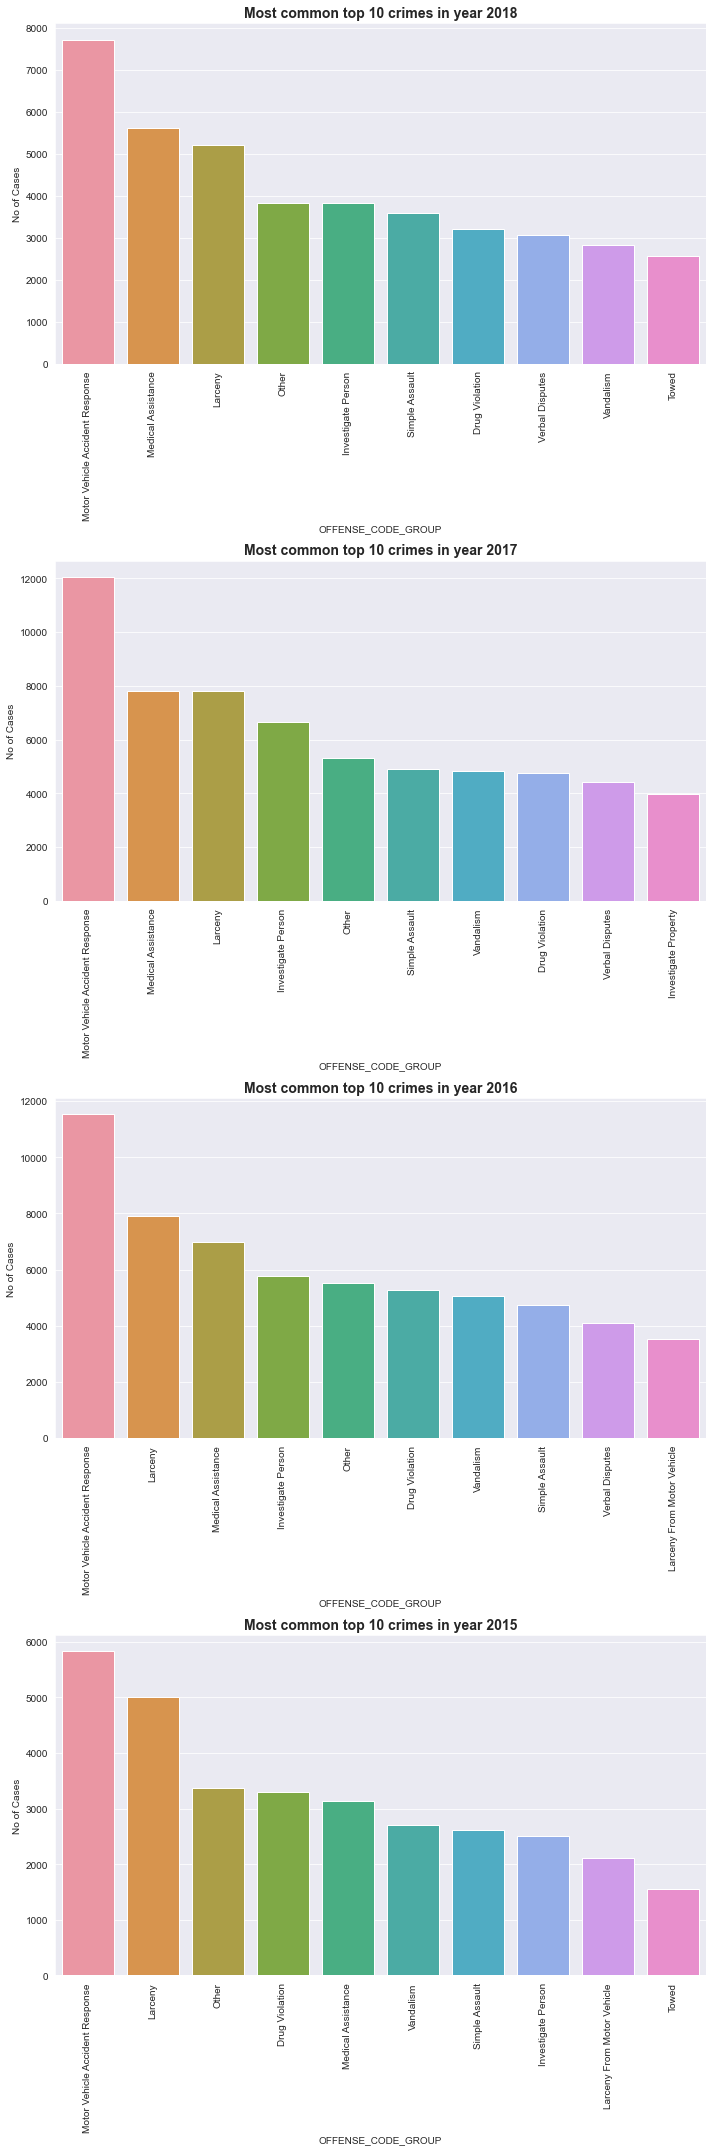

In [19]:
df_y=df.groupby(['YEAR','OFFENSE_CODE_GROUP'])['INCIDENT_NUMBER'].count()
fig,ax=plt.subplots(nrows=4, ncols=1,figsize=(10,30))
for j,i in enumerate(df['YEAR'].unique()):
    sns.barplot(df_y.loc[i].nlargest(10).index,df_y.loc[i].nlargest(10),ax=ax[j])
    ax[j].set_title('Most common top 10 crimes in year '+str(i),fontsize=14, fontweight='bold')
    ax[j].set_xticklabels(rotation=90,labels=df_y.loc[i].nlargest(10).index)
    ax[j].set(ylabel='No of Cases')
    plt.tight_layout()

Overall major crimes during the period of 4 years

In [20]:
t_crimes=df['OFFENSE_CODE_GROUP'].value_counts()[:10] # Most common top 10 crimes
t_crimes

Motor Vehicle Accident Response    37132
Larceny                            25935
Medical Assistance                 23540
Investigate Person                 18750
Other                              18075
Drug Violation                     16548
Simple Assault                     15826
Vandalism                          15415
Verbal Disputes                    13099
Towed                              11287
Name: OFFENSE_CODE_GROUP, dtype: int64

Text(0, 0.5, 'No of Cases')

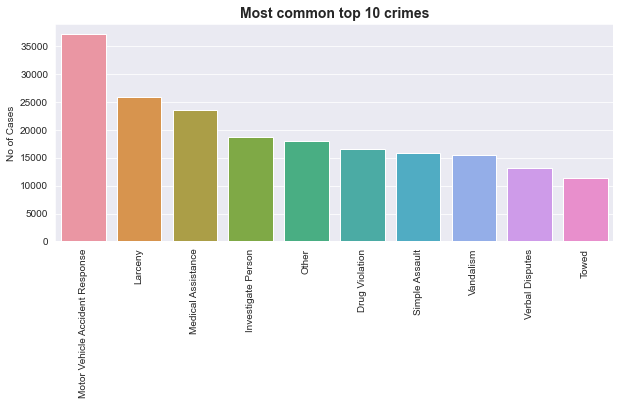

In [21]:
plt.figure(figsize=(10,4))
sns.barplot(t_crimes.index,t_crimes)
plt.xticks(rotation=90)
plt.title('Most common top 10 crimes',fontsize=14, fontweight='bold')
plt.ylabel('No of Cases')

# Which District and UCR has highest crime rate?

Text(0, 0.5, 'No of Cases')

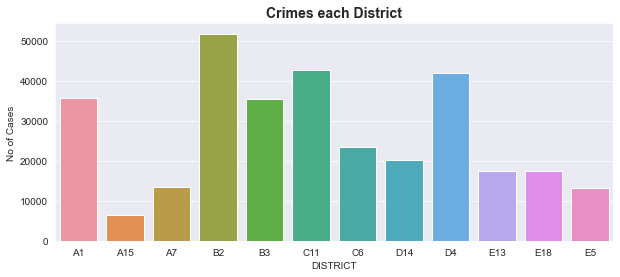

In [22]:
df_1=df.groupby('DISTRICT')['SHOOTING'].count()
plt.figure(figsize=(10,4))
sns.barplot(df_1.index,df_1)
#plt.xticks(rotation=90)
plt.title('Crimes each District',fontsize=14, fontweight='bold')
plt.ylabel('No of Cases')

Text(0, 0.5, 'No of Cases')

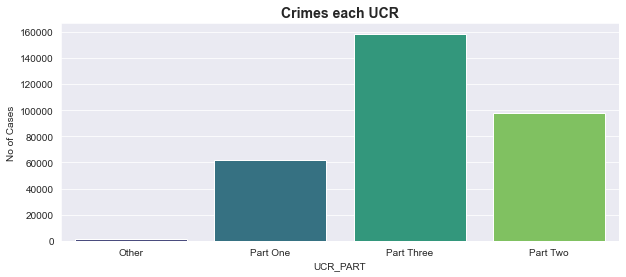

In [23]:

df_1=df.groupby('UCR_PART')['SHOOTING'].count()
plt.figure(figsize=(10,4))
sns.barplot(df_1.index,df_1,palette='viridis')
#plt.xticks(rotation=90)
plt.title('Crimes each UCR',fontsize=14, fontweight='bold')
plt.ylabel('No of Cases')

# Where are different types of crimes most likely to occur?

In [24]:
df1=df.groupby(['DISTRICT','OFFENSE_CODE_GROUP'])['SHOOTING'].count().reset_index().sort_values(['DISTRICT','SHOOTING'],ascending=False).reset_index(drop=True)
df1.columns=['DISTRICT','OFFENSE_CODE_GROUP','Cases']
df1

,DISTRICT,OFFENSE_CODE_GROUP,Cases
0,E5,Motor Vehicle Accident Response,1813
1,E5,Medical Assistance,1509
2,E5,Investigate Person,1059
3,E5,Other,804
4,E5,Drug Violation,705
...,...,...,...
717,A1,Homicide,5
718,A1,Phone Call Complaints,3
719,A1,Biological Threat,2
720,A1,HOME INVASION,1


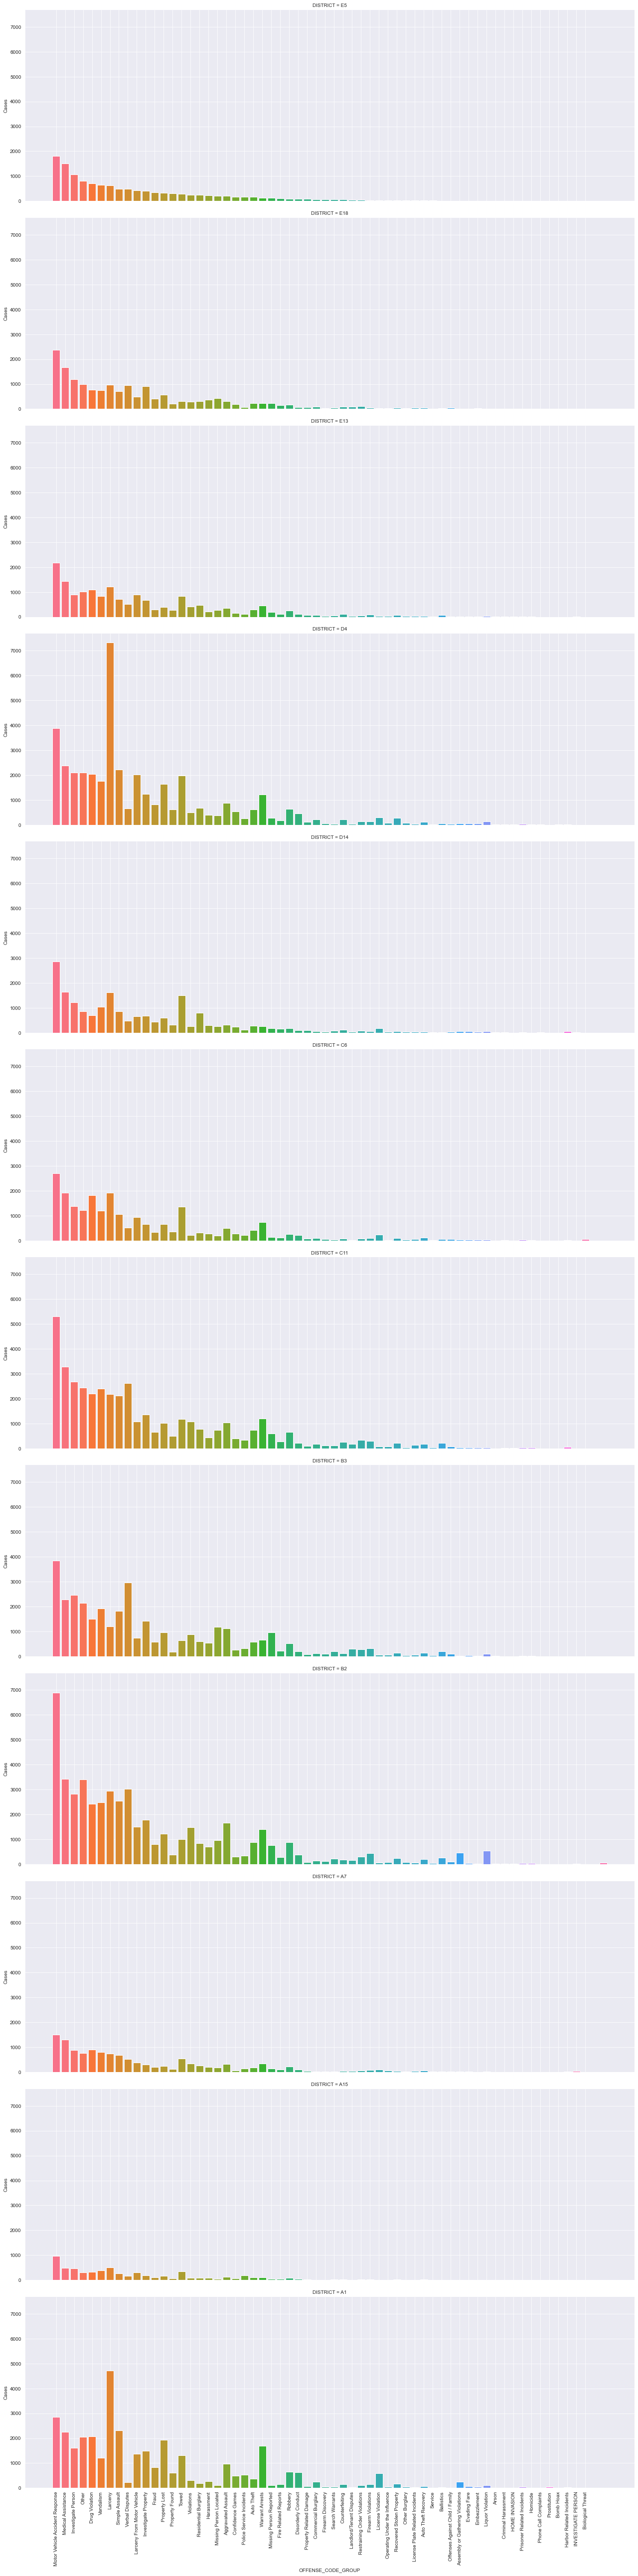

In [25]:
g=sns.FacetGrid(df1,row='DISTRICT',height=6,aspect=3,hue='OFFENSE_CODE_GROUP')
g.map(plt.bar,'OFFENSE_CODE_GROUP','Cases')
plt.xticks(rotation=90)
plt.tight_layout(pad=1.5)

Above plot suggests that Districts A1, B2, C11 & D4 has a lot of different types of crimes

# Does the frequency of crimes change over the day? Week? Year?

In [26]:
df.head(4)

,INCIDENT_NUMBER,OFFENSE_CODE_GROUP,DISTRICT,SHOOTING,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART
OCCURRED_ON_DATE,,,,,,,,,
2018-09-02 13:00:00,I182070945,Larceny,D14,0,2018,9,Sunday,13,Part One
2018-08-21 00:00:00,I182070943,Vandalism,C11,0,2018,8,Tuesday,0,Part Two
2018-09-03 19:27:00,I182070941,Towed,D4,0,2018,9,Monday,19,Part Three
2018-09-03 21:16:00,I182070940,Investigate Property,D4,0,2018,9,Monday,21,Part Three


Crime rate or no of crimes refers to the unique crimes registed so we will consider INCIDENT_NUMBER as unique case/crime

Text(0, 0.5, 'No of Cases')

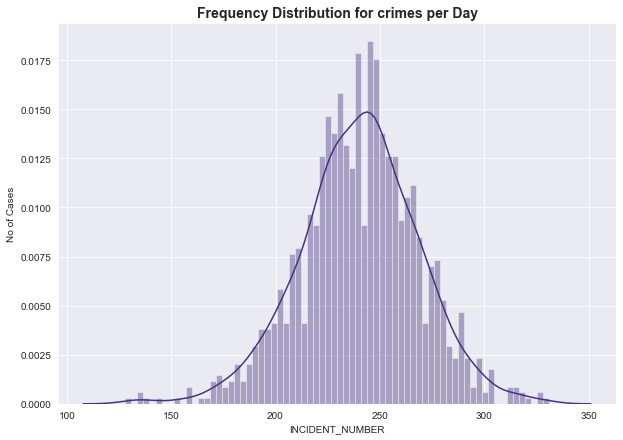

In [27]:
plt.figure(figsize=(10,7))
sns.distplot(df.reset_index().groupby('INCIDENT_NUMBER')['OCCURRED_ON_DATE'].min().reset_index().set_index('OCCURRED_ON_DATE').resample('D')['INCIDENT_NUMBER'].count(),bins=70)
plt.title('Frequency Distribution for crimes per Day',fontsize=14, fontweight='bold')
plt.ylabel('No of Cases')

In [28]:
df2=df.groupby('INCIDENT_NUMBER')['YEAR','MONTH','DAY_OF_WEEK','HOUR'].min().reset_index()
df2

,INCIDENT_NUMBER,YEAR,MONTH,DAY_OF_WEEK,HOUR
0,142052550,2015,6,Monday,0
1,I010370257-00,2016,5,Tuesday,19
2,I030217815-08,2015,7,Thursday,13
3,I050310906-00,2016,6,Sunday,17
4,I060168073-00,2018,1,Saturday,14
...,...,...,...,...,...
282512,I182070938,2018,9,Monday,21
282513,I182070940,2018,9,Monday,21
282514,I182070941,2018,9,Monday,19
282515,I182070943,2018,8,Tuesday,0


Lets plot frequency of crimes over different datetime parts

Text(0, 0.5, 'No of Cases')

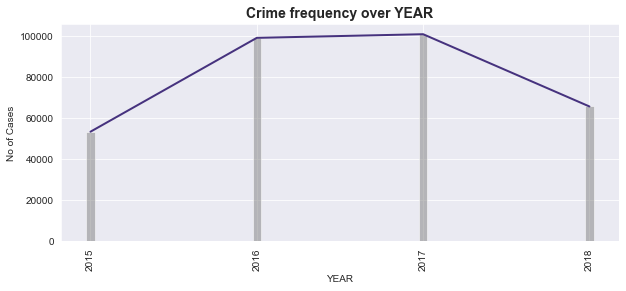

In [29]:
plot='YEAR'
df2=df.groupby(plot)['INCIDENT_NUMBER'].count()
plt.figure(figsize=(10,4))
sns.lineplot(df2.index,df2,lw=2,markers='o')
plt.bar(df2.index,df2,width=0.05,alpha=0.5,color='grey')
plt.xticks(df2.index,rotation=90)
plt.title('Crime frequency over '+plot,fontsize=14, fontweight='bold')
plt.ylabel('No of Cases')

Text(0, 0.5, 'No of Cases')

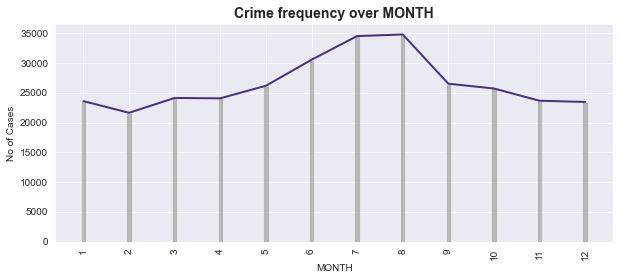

In [30]:
plot='MONTH'
df2=df.groupby(plot)['INCIDENT_NUMBER'].count()
plt.figure(figsize=(10,4))
sns.lineplot(df2.index,df2,lw=2,markers='o')
plt.bar(df2.index,df2,width=0.12,alpha=0.5,color='grey')
plt.xticks(df2.index,rotation=90)
plt.title('Crime frequency over '+plot,fontsize=14, fontweight='bold')
plt.ylabel('No of Cases')

Text(0, 0.5, 'No of Cases')

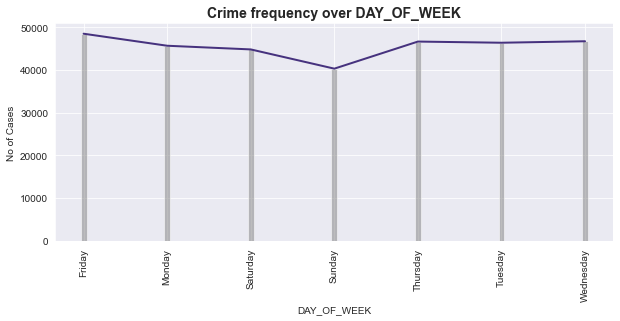

In [31]:
plot='DAY_OF_WEEK'
df2=df.groupby(plot)['INCIDENT_NUMBER'].count()
plt.figure(figsize=(10,4))
sns.lineplot(df2.index,df2,lw=2,markers='o')
plt.bar(df2.index,df2,width=0.07,alpha=0.5,color='grey')
plt.xticks(df2.index,rotation=90)
plt.title('Crime frequency over '+plot,fontsize=14, fontweight='bold')
plt.ylabel('No of Cases')

Text(0, 0.5, 'No of Cases')

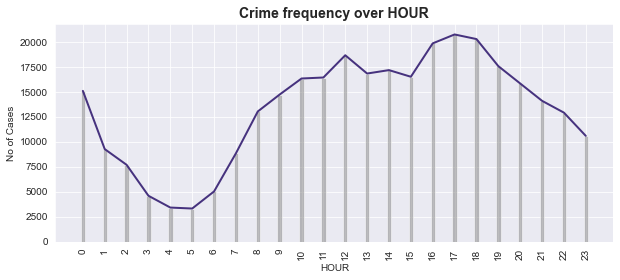

In [32]:
plot='HOUR'
df2=df.groupby(plot)['INCIDENT_NUMBER'].count()
plt.figure(figsize=(10,4))
sns.lineplot(df2.index,df2,lw=2,markers='o')
plt.bar(df2.index,df2,width=0.2,alpha=0.5,color='grey')
plt.xticks(df2.index,rotation=90)
plt.title('Crime frequency over '+plot,fontsize=14, fontweight='bold')
plt.ylabel('No of Cases')

# Analysing the occurance of top 5 crimes based on Weekday

In [33]:
df.head(3)

,INCIDENT_NUMBER,OFFENSE_CODE_GROUP,DISTRICT,SHOOTING,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART
OCCURRED_ON_DATE,,,,,,,,,
2018-09-02 13:00:00,I182070945,Larceny,D14,0,2018,9,Sunday,13,Part One
2018-08-21 00:00:00,I182070943,Vandalism,C11,0,2018,8,Tuesday,0,Part Two
2018-09-03 19:27:00,I182070941,Towed,D4,0,2018,9,Monday,19,Part Three


In [34]:
dfee=df.copy()
dfee['DAY_OF_WEEK']=dfee['DAY_OF_WEEK'].map({'Sunday':6, 'Tuesday':1, 'Monday':0, 'Saturday':5, 'Friday':4, 'Wednesday':2,
       'Thursday':3})

In [35]:
tcrimes=dfee['OFFENSE_CODE_GROUP'].value_counts().index[:5] # Top 5 crimes
tcrimes

Index(['Motor Vehicle Accident Response', 'Larceny', 'Medical Assistance',
       'Investigate Person', 'Other'],
      dtype='object')

In [36]:
crimes=dfee.groupby(['OFFENSE_CODE_GROUP','DAY_OF_WEEK'])['INCIDENT_NUMBER'].nunique().reset_index().sort_values('DAY_OF_WEEK',)
crimes

,OFFENSE_CODE_GROUP,DAY_OF_WEEK,INCIDENT_NUMBER
0,Aggravated Assault,0,990
200,Investigate Property,0,1539
193,Investigate Person,0,2665
189,INVESTIGATE PERSON,0,1
414,Vandalism,0,2132
...,...,...,...
227,Larceny From Motor Vehicle,6,1631
213,Landlord/Tenant Disputes,6,114
206,Investigate Property,6,1554
287,Offenses Against Child / Family,6,66


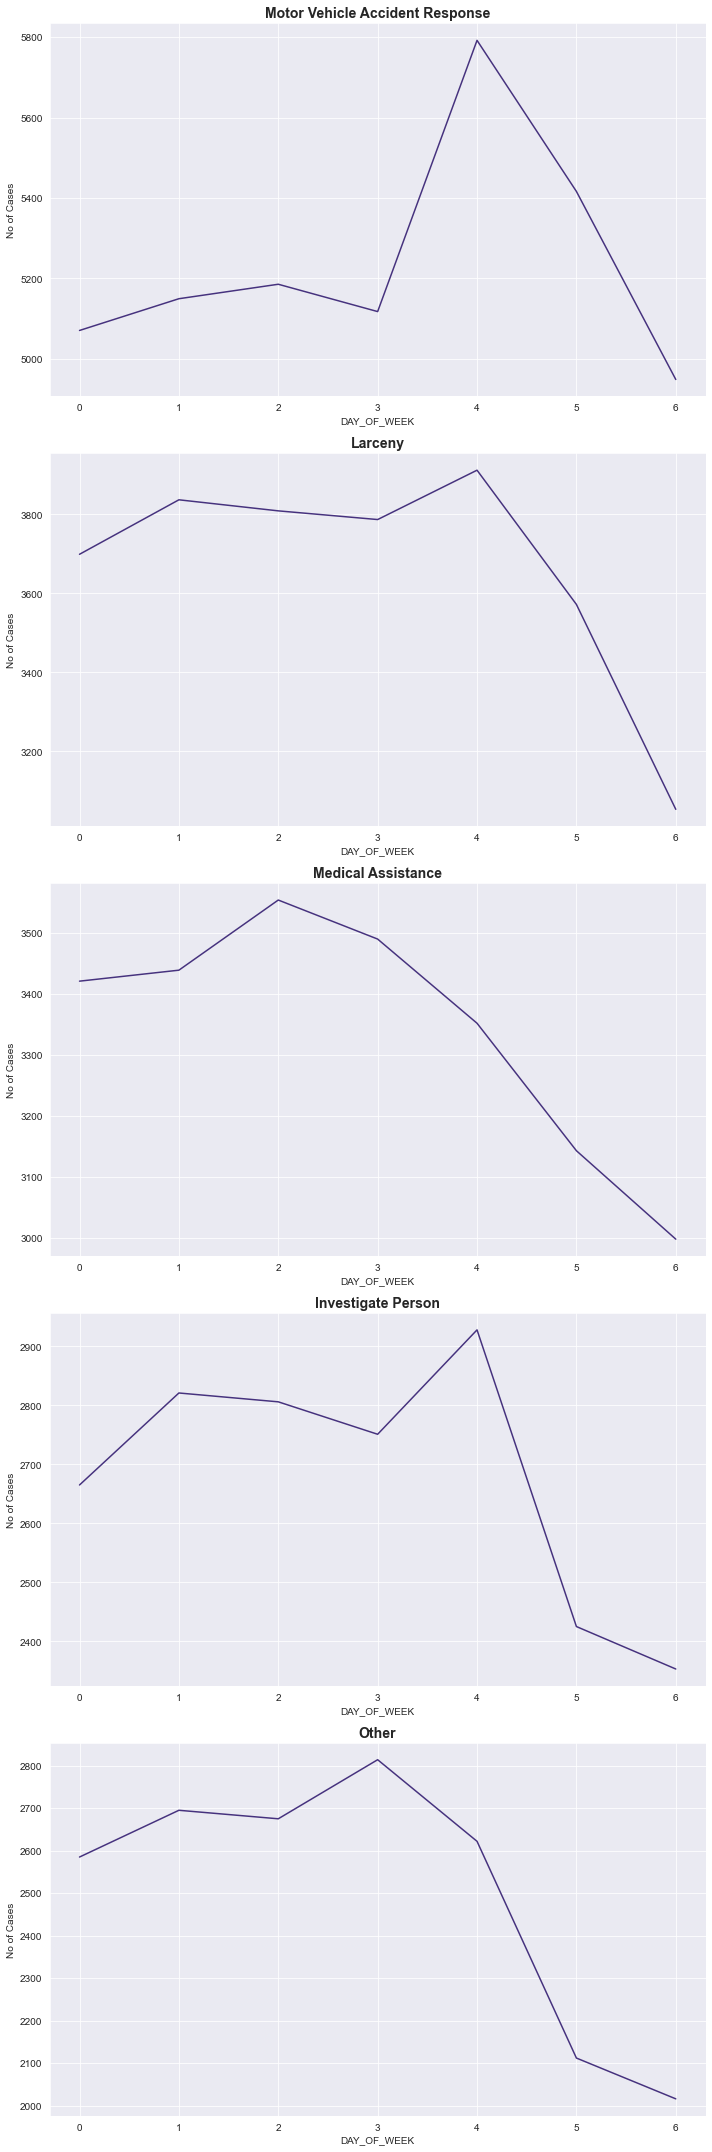

In [37]:
fig,ax=plt.subplots(nrows=len(tcrimes), ncols=1,figsize=(10,30))
for j,i in enumerate(tcrimes):
    sns.lineplot(crimes.loc[crimes['OFFENSE_CODE_GROUP']==i]['DAY_OF_WEEK'],crimes.loc[crimes['OFFENSE_CODE_GROUP']==i]['INCIDENT_NUMBER'],ax=ax[j])
    ax[j].set_title(i,fontsize=14, fontweight='bold')
    #ax[j].set_xticklabels(rotation=90,labels=df_y.loc[i].nlargest(10).index)
    ax[j].set(ylabel='No of Cases')
    plt.tight_layout()

# Is it possible to forecast the daily frequency of crimes? How?

In [38]:
df.head()

,INCIDENT_NUMBER,OFFENSE_CODE_GROUP,DISTRICT,SHOOTING,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART
OCCURRED_ON_DATE,,,,,,,,,
2018-09-02 13:00:00,I182070945,Larceny,D14,0,2018,9,Sunday,13,Part One
2018-08-21 00:00:00,I182070943,Vandalism,C11,0,2018,8,Tuesday,0,Part Two
2018-09-03 19:27:00,I182070941,Towed,D4,0,2018,9,Monday,19,Part Three
2018-09-03 21:16:00,I182070940,Investigate Property,D4,0,2018,9,Monday,21,Part Three
2018-09-03 21:05:00,I182070938,Investigate Property,B3,0,2018,9,Monday,21,Part Three


In [39]:
df.index.min(),df.index.max()

(Timestamp('2015-06-15 00:00:00'), Timestamp('2018-09-03 21:25:00'))

Creating a data dframe out of df that treats INCIDENT_NUMBER as unique and has sum of crimes reported perday

In [40]:
dfe=df.reset_index().groupby('INCIDENT_NUMBER')['OCCURRED_ON_DATE'].min().reset_index().set_index('OCCURRED_ON_DATE').resample('d')['INCIDENT_NUMBER'].count()
dfe=pd.DataFrame(dfe)

In [41]:
dfe.index.name='Date'
dfe.columns=['y']
dfe.head()

,y
Date,
2015-06-15,239
2015-06-16,217
2015-06-17,208
2015-06-18,269
2015-06-19,249


Lets Visualize

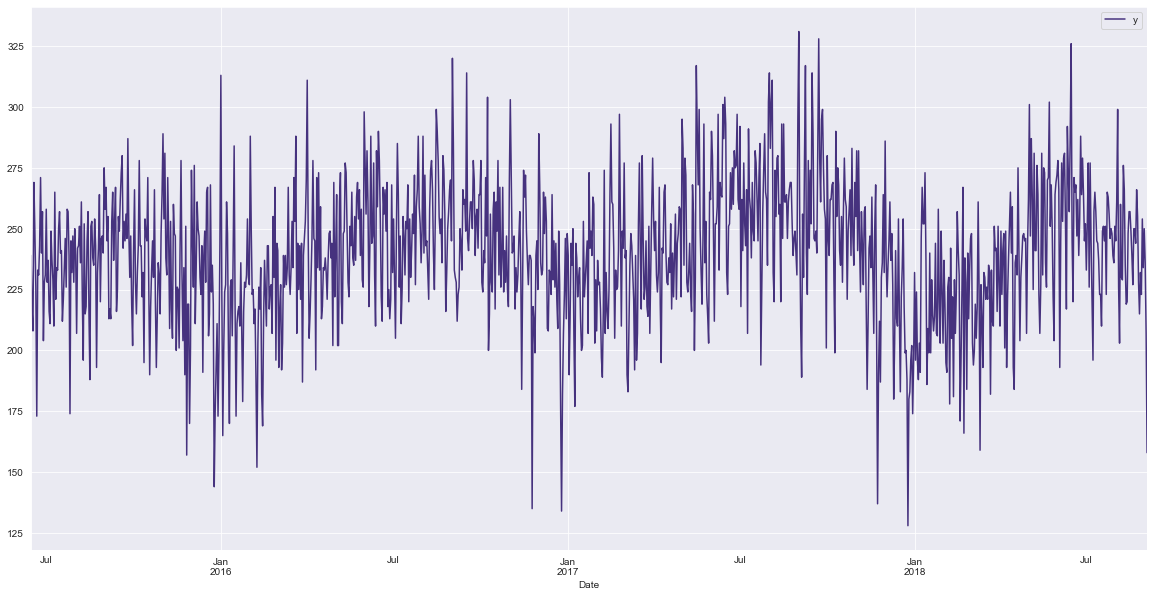

In [42]:
(dfe).plot(figsize=(20,10))

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose as sd

In [44]:
dec=sd(dfe)

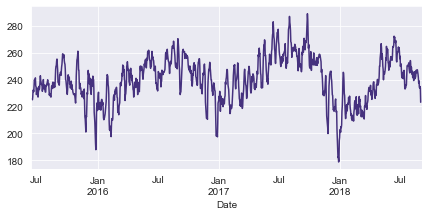

In [45]:
dec.trend.plot(figsize=(7,3)) #shows a clear trend

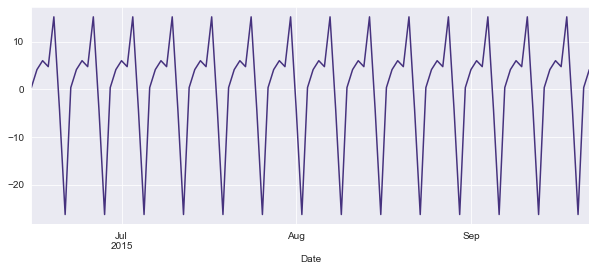

In [46]:
dec.seasonal.iloc[:100].plot(figsize=(10,4)) #shows very crisp seasonality

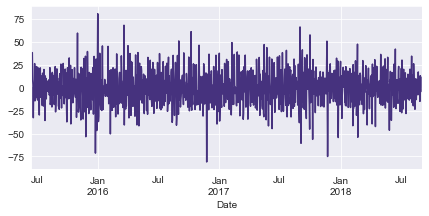

In [47]:
dec.resid.plot(figsize=(7,3))

Lets apply ADFULLER test an check if the Series is stationary or not

In [48]:
from statsmodels.tsa.stattools import adfuller

In [49]:
adf=adfuller(dfe)

In [50]:
print('Test Statistics = '+str(adf[0]),'| p-value = '+str(adf[1]))                     # adf test statistic, p-value 

Test Statistics = -3.283826760956271 | p-value = 0.015617079893379867


as p-values is less than 0.05 we will conclude that the the series is already stationary, so (d=0)

In [51]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

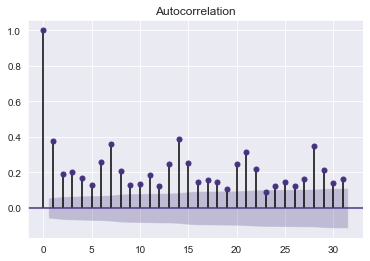

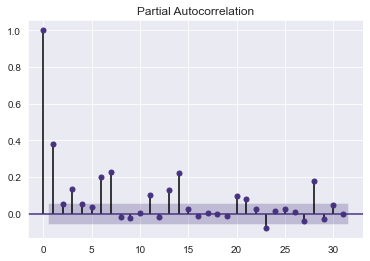

In [52]:
plot_acf(dfe),plot_pacf(dfe)        # IN ACF plot we see peaks after a period of 7 intervals, so (m=7)

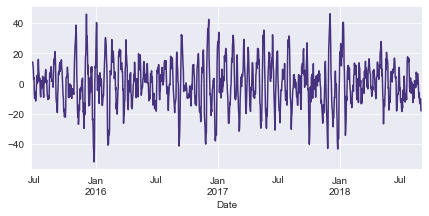

In [53]:
sd(dfe.diff(7).dropna()).trend.plot(figsize=(7,3))

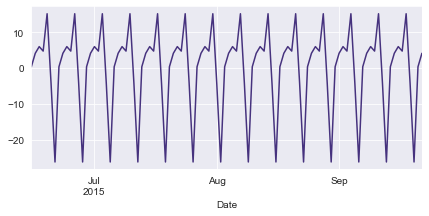

In [54]:
sd(dfe).seasonal.iloc[:100].plot(figsize=(7,3))

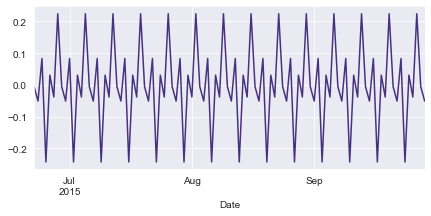

In [55]:
sd(dfe.diff(7).dropna()).seasonal.iloc[:100].plot(figsize=(7,3))

In [56]:
diff7=dfe.diff(7).dropna()

For finding P & Q we plot ACF & PACF at intervals of 7 

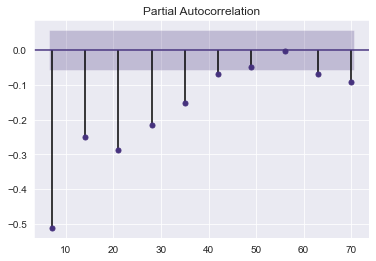

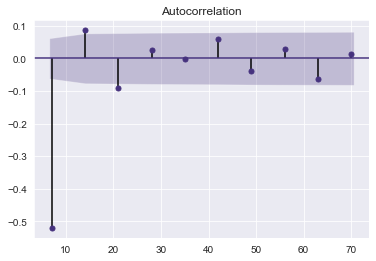

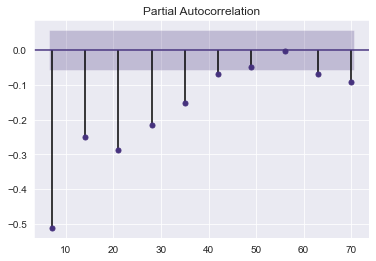

In [57]:
plot_acf(diff7,lags=[i*7 for i in range(1,11)]) 
plot_pacf(diff7,lags=[i*7 for i in range(1,11)])

Lets automate the process a bit by using pmdarima

In [58]:
import pmdarima as pm

In [59]:
model=pm.auto_arima(dfe,d=0,start_p=0,start_q=0,max_p=2,max_q=2,seasonal=True,m=7,D=1,start_P=0,start_Q=0,max_P=1,max_Q=1,n_jobs=-1,trace=True,error_action='ignore')

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(0,1,0,7) [intercept=True]; AIC=11435.667, BIC=11445.797, Time=0.072 seconds
Fit ARIMA(1,0,0)x(1,1,0,7) [intercept=True]; AIC=11013.288, BIC=11033.547, Time=0.798 seconds
Fit ARIMA(0,0,1)x(0,1,1,7) [intercept=True]; AIC=10759.587, BIC=10779.846, Time=1.067 seconds
Fit ARIMA(0,0,0)x(0,1,0,7) [intercept=False]; AIC=11433.667, BIC=11438.732, Time=0.067 seconds
Fit ARIMA(0,0,1)x(0,1,0,7) [intercept=True]; AIC=11381.558, BIC=11396.752, Time=0.457 seconds
Fit ARIMA(0,0,1)x(1,1,1,7) [intercept=True]; AIC=10782.731, BIC=10808.055, Time=3.610 seconds
Near non-invertible roots for order (0, 0, 1)(1, 1, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,0,1)x(1,1,0,7) [intercept=True]; AIC=11019.370, BIC=11039.630, Time=0.966 seconds
Fit ARIMA(0,0,0)x(0,1,1,7) [intercept=True]; AIC=10840.280, BIC=10855.474, Time=0.540 seconds
Fit ARIMA(1,0,1)x(0,1,1,7) [intercept=True]; A

In [60]:
model.summary()            # WE clealry saw that out of all models SARIMAX(1,0,2)x(0,1,1,7) performed better with lowest aic 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1177
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 7)   Log Likelihood               -5305.043
Date:                             Tue, 26 May 2020   AIC                          10622.086
Time:                                     16:43:05   BIC                          10652.475
Sample:                                          0   HQIC                         10633.548
                                            - 1177                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.001      0.293      0.770      -0.002       0.003
ar.L1          0.9850      0.008    130.244      0.000       0.970       1.000
ma.L1         -0.7264      0.028    -26.270      0.000      -0.781      -0.672
ma.L2         -0.1638      0.028     -5.865      0.000      -0.219      -0.109
ma.S.L7       -0.9934      0.026    -37.947      0.000      -1.045      -0.942
sigma2       489.8971     18.747     26.132      0.000     453.153     526.641
===================================================================================
Ljung-Box (Q):                       72.76   Jarque-Bera (JB):               141.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -0.22
Prob(H) (two-sided):                  0.79   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

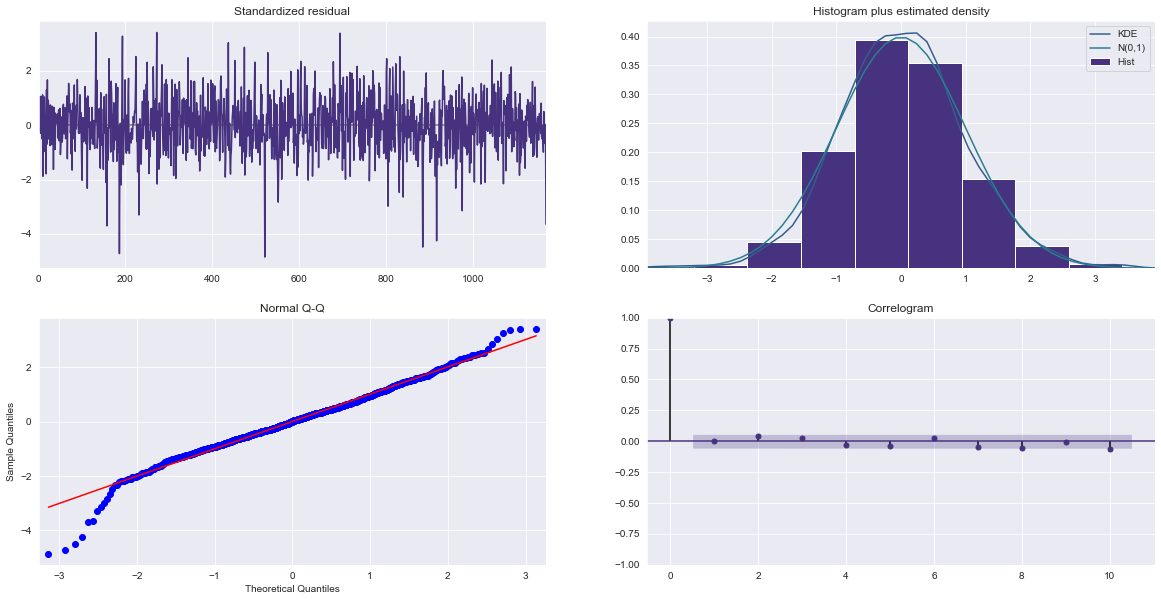

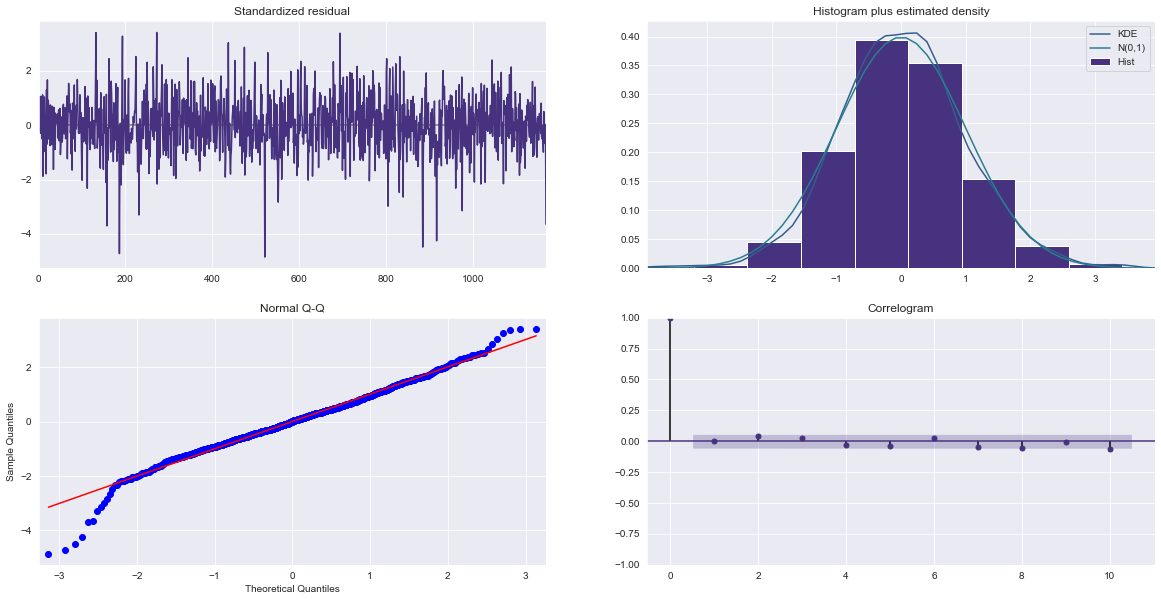

In [61]:
model.plot_diagnostics(figsize=(20,10))

Applying SARIMAX(1,0,2)x(0,1,1,7)

In [62]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [63]:
best_model=SARIMAX(dfe,order=(1,0,2),seasonal_order=(0,1,1,7))

In [64]:
res=best_model.fit()

In [65]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1177
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 7)   Log Likelihood               -5304.347
Date:                             Tue, 26 May 2020   AIC                          10618.694
Time:                                     16:43:11   BIC                          10644.018
Sample:                                 06-15-2015   HQIC                         10628.245
                                      - 09-03-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9896      0.007    151.267      0.000       0.977       1.002
ma.L1         -0.7351      0.027    -26.744      0.000      -0.789      -0.681
ma.L2         -0.1687      0.028     -6.046      0.000      -0.223      -0.114
ma.S.L7       -0.9997      0.474     -2.109      0.035      -1.929      -0.071
sigma2       493.3113    232.816      2.119      0.034      37.000     949.622
===================================================================================
Ljung-Box (Q):                       72.30   Jarque-Bera (JB):               142.41
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -0.22
Prob(H) (two-sided):                  0.77   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
np.mean((abs(res.resid)))

18.554158581521712

In sample Predicitons

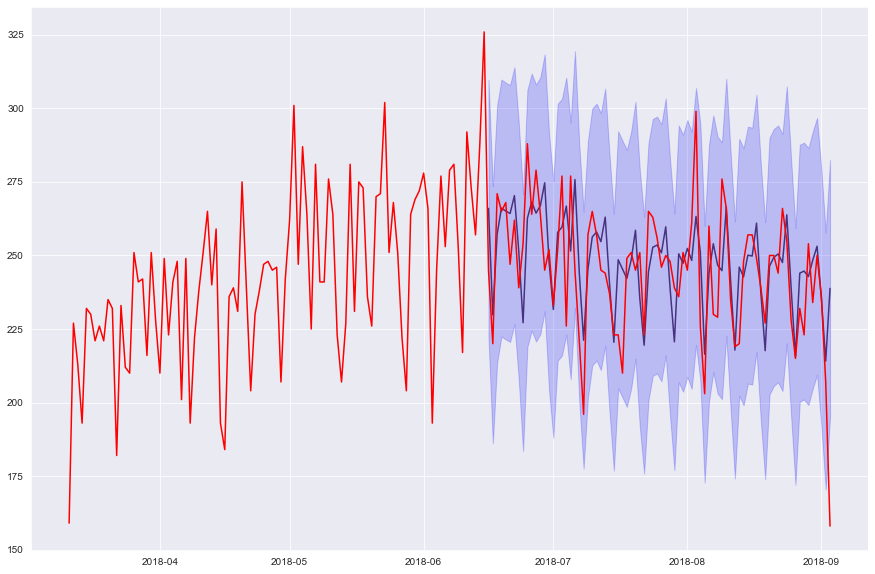

In [67]:
pred=res.get_prediction(-80)
mean=pred.predicted_mean
coef=pred.conf_int()
plt.figure(figsize=(15,10))
plt.plot(mean)
plt.plot(dfe.iloc[1000:],color='r')
plt.fill_between(mean.index,coef['lower y'],coef['upper y'],alpha=0.2,color='b')

Evaluating model performance based on error

In [68]:
from sklearn.metrics import mean_squared_error

In [69]:
print('MSE = ',mean_squared_error((dfe.iloc[-80:]),mean),'| RMSE = ',np.sqrt(mean_squared_error((dfe.iloc[-80:]),mean)))

MSE =  331.96616834096073 | RMSE =  18.219938757881728


Forecasting Future crimes

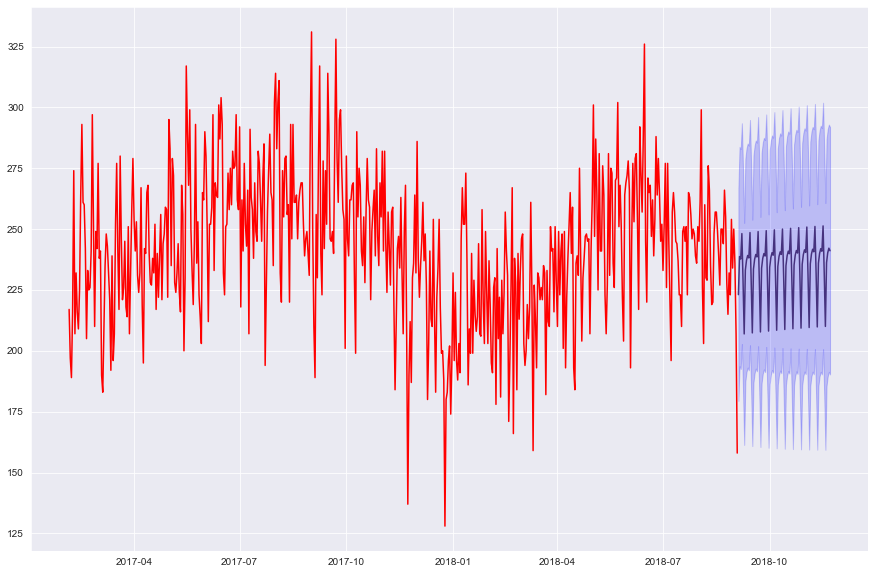

In [70]:
pred=res.get_forecast(80)
mean=pred.predicted_mean
coef=pred.conf_int()
plt.figure(figsize=(15,10))
plt.plot(mean)
plt.plot(dfe.iloc[600:],color='r')
plt.fill_between(mean.index,coef['lower y'],coef['upper y'],alpha=0.2,color='b')

# Poster depicting major Crimes 

In [71]:
from wordcloud import WordCloud

In [72]:
wordcloud = WordCloud(background_color='black',width=4000,height=2200,colormap='viridis').generate(" ".join(df.OFFENSE_CODE_GROUP))

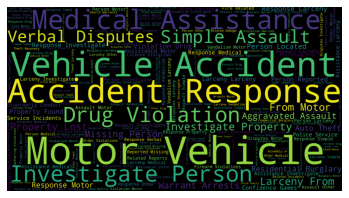

In [73]:
pic=plt.imshow(wordcloud)
plt.grid(False)
plt.axis(False)
plt.savefig('Major crimes poster.png',dpi=400)

<font size ='4'>**Results**</font>
* Just run the 2 columns below to hear the results drawn from above analysis

In [4]:
tts=gTTS("""
I analysed and visualized Boston Crimes Dataset using following libraries
Numpy, Pandas, Matplotlib, Seaborn
Following insights could be drawn from this analysis
Majority of cases are of Motor Vehicle Accident
Over the past year cases on Larceny and Drug voilation has increased a lot, while Cases on Medical Assistance has lowered.
Districts like B2, C11 and D4 has high crime rate
Most cases of Motor Vehicle Accident happened in B2 & C11 Districts
Most cases of Larceny happened in D4 District
During summer, crime rate increases
During Weekends, crime rate decreases
During Evening crime rate increses especially during 4-6 P.M
There are plots that suggest occurance of Major crime during weekdays

I also build a Timeseries Model that Forecasts daily crime rates during using SARIMAX model
The model could be trained on different data specific to geographical location and type of offence that will result in forecasting the chances of major crimes in specific locations
""")

In [5]:
tts.save('result.wav')
Audio('result.wav',autoplay=True)